In [1]:
%cd ../
import sys
sys.path.append('..')
import numpy as np
import pandas as pd

import requests
import scipy 
from datetime import datetime
from matplotlib import pyplot as plt
from stix.core import stix_datatypes as sdt
from stix.core import mongo_db as db
from stix.apis import net
from stix.core import stix_datetime
from stix.analysis import flare_detection as fld
%matplotlib inline

/home/xiaohl/FHNW/STIX/gsw/STIX_python
[INFO 2020-09-10 18:49:15] : IDB loaded from stix/data/idb/idb.sqlite


In [2]:
mdb=db.MongoDB()
SPID = 54118

In [3]:
def get_lc_data(start_unix, duration):
    # query database and retrievedb.
    packets=mdb.get_quicklook_packets('lc', start_unix, duration)#, sort_field='header.unix_time')
 
    
    #packets = mdb.select_packets_by_run(file_id, SPID)
    if not packets:
        print('No lc found')
        return None, None

    lightcurves = {}
    unix_time = []
    last_time=0
    for pkt in packets:
        packet = sdt.Packet(pkt)
        if not packet.isa(SPID):
            continue
        #fig = None
        if last_time>=packet['unix_time']:
            continue
        last_time=packet['unix_time']

        scet_coarse = packet[1].raw
        scet_fine = packet[2].raw
        start_scet = scet_coarse + scet_fine / 65536.

        int_duration = (packet[3].raw + 1) * 0.1
        num_lc_points = packet.get('NIX00270/NIX00271')[0]
        lc = packet.get('NIX00270/NIX00271/*.eng')[0]
        UTC = packet['header']['UTC']
        for i in range(len(lc)):
            if i not in lightcurves:
                lightcurves[i] = []
            lightcurves[i].extend(lc[i])
        unix_time.extend([
            stix_datetime.scet2unix(start_scet + x * int_duration)
            for x in range(num_lc_points[0])
        ])
    return np.array(lightcurves[0]), np.array(unix_time)


#lc, t=get_lc_data(1591488000,600)
#f=plt.figure()
#plt.plot(t,lc)
#plt.show()
    


In [4]:
flare_data=[]
margin_seconds=900
confirmed_flares=mdb.get_db()['flares'].find()
for fl in confirmed_flares:
    start_unix=float(fl['start_unix_time'])
    duration=float(fl['duration'])
    lc,unix_time=get_lc_data(start_unix,duration)
    if lc is not None:
        flare_data.append({'lc':lc,'t':unix_time,'_id':fl['_id']})
    
#f=plt.figure()
#plt.plot(flare_data[0]['t'], flare_data[0]['lc'])    
#plt.show()

No lc found


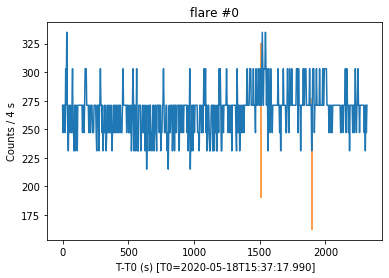

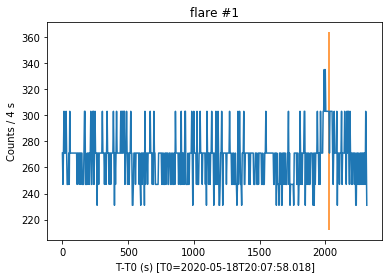

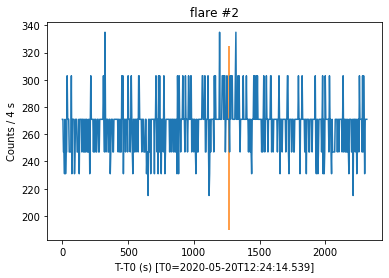

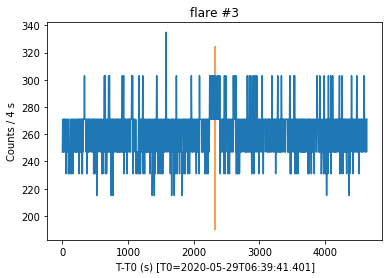

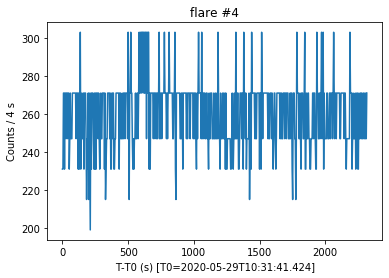

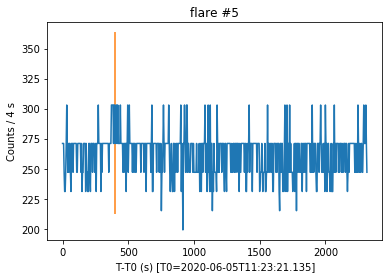

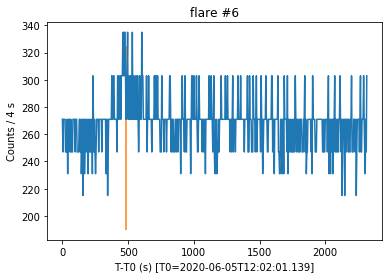

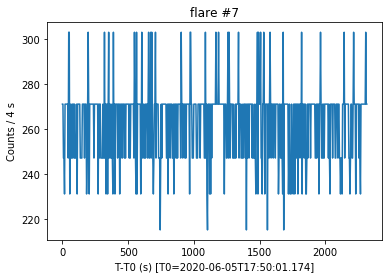

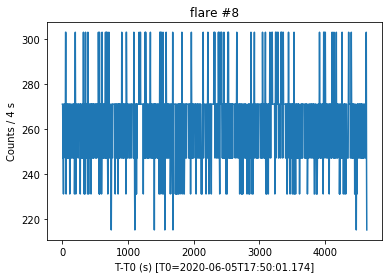

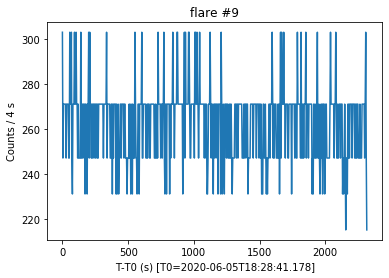

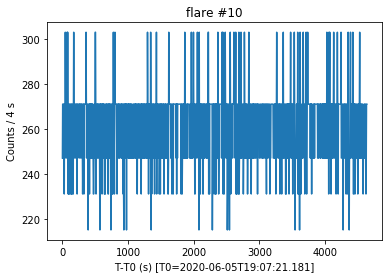

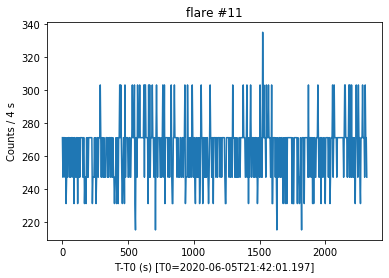

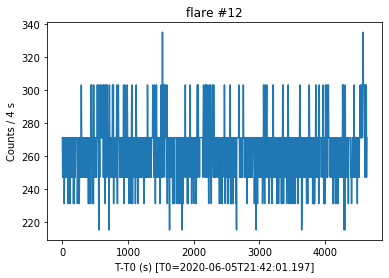

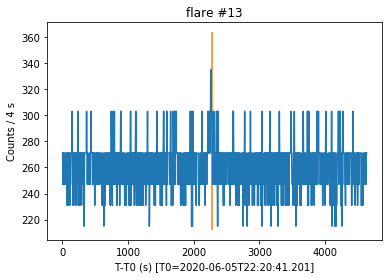

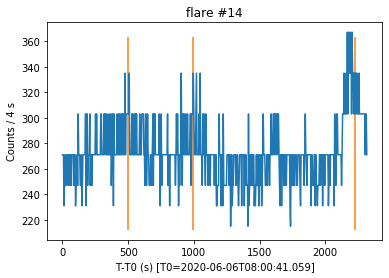

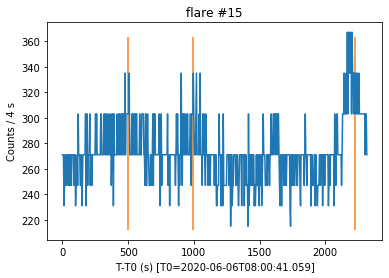

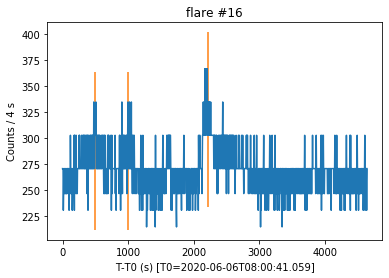

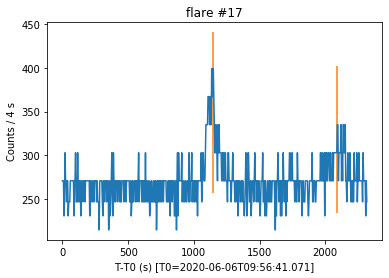

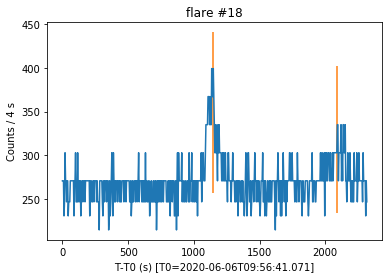

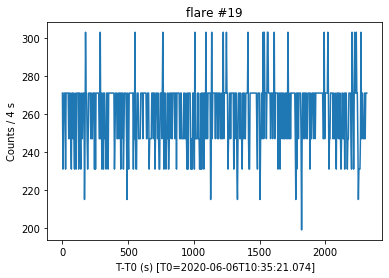

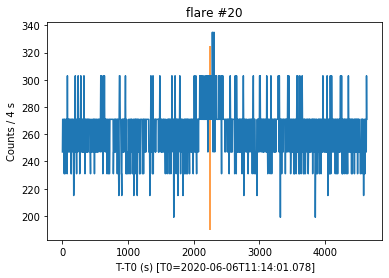

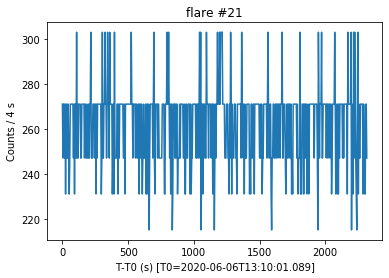

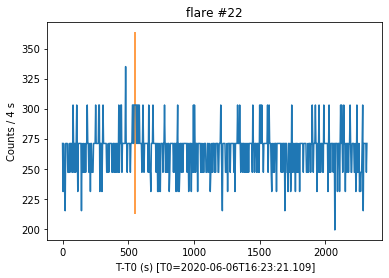

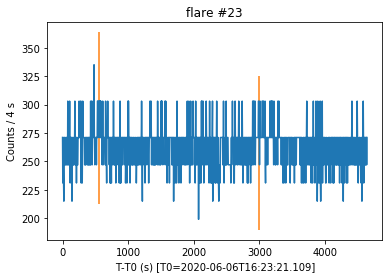

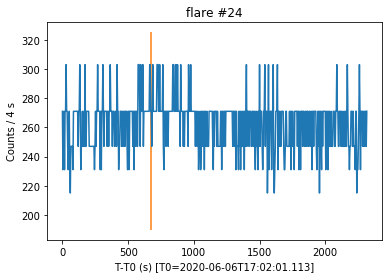

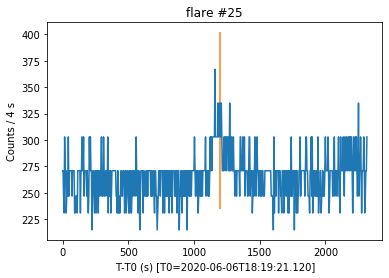

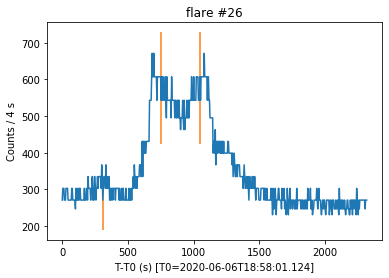

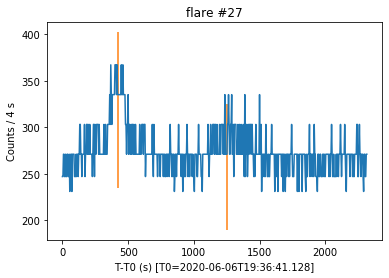

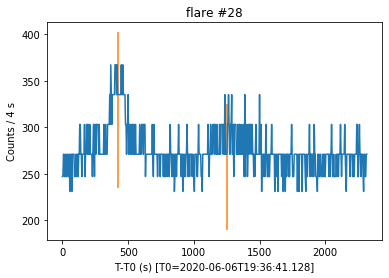

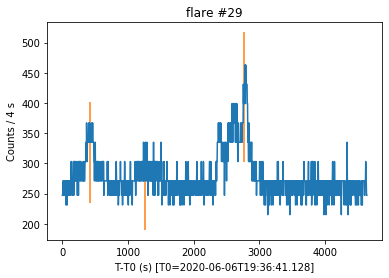

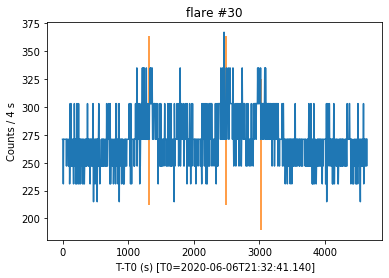

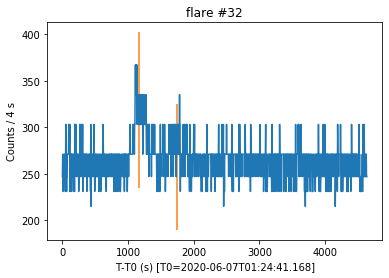

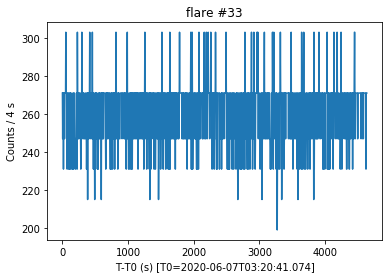

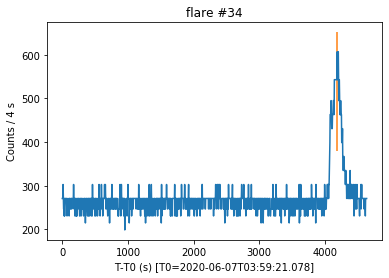

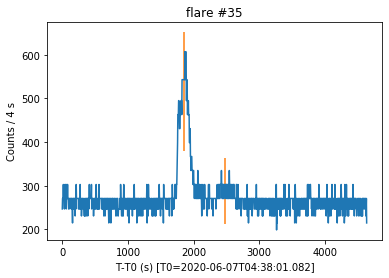

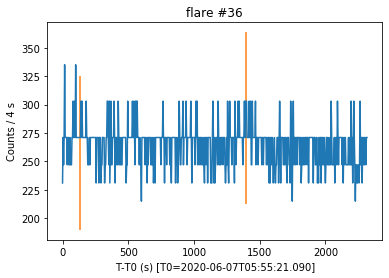

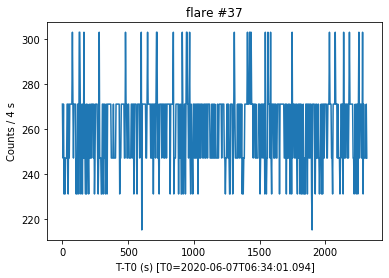

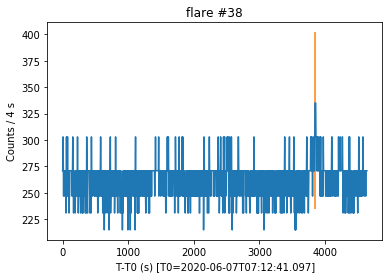

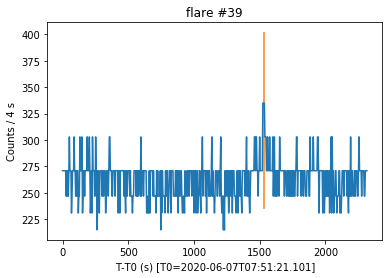

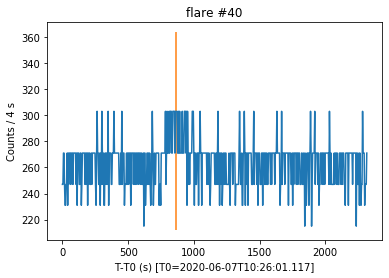

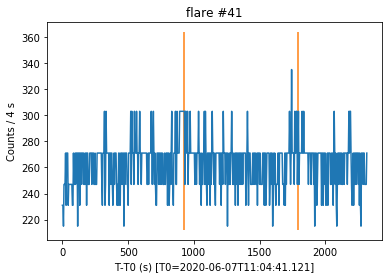

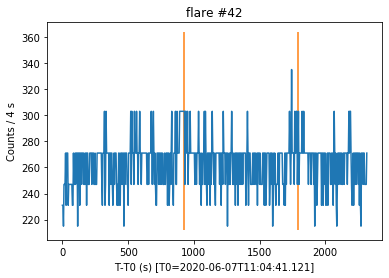

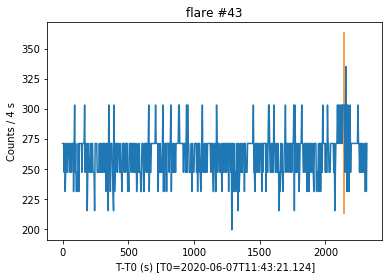

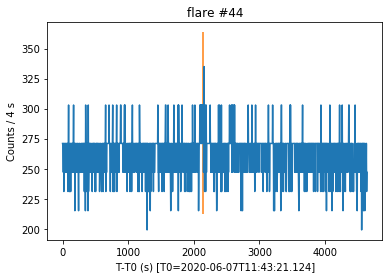

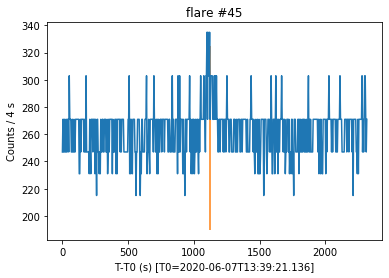

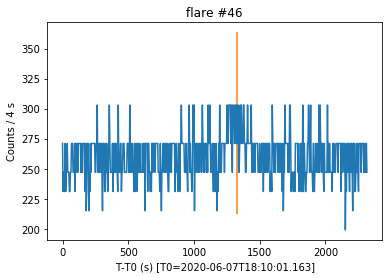

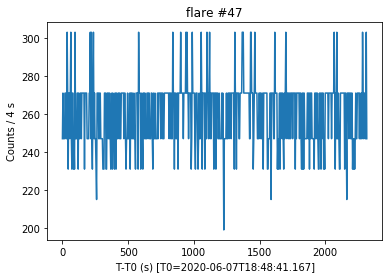

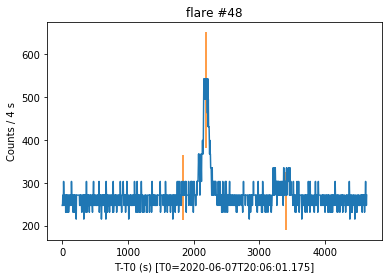

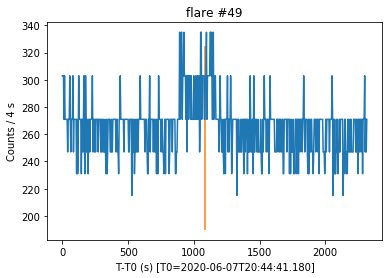

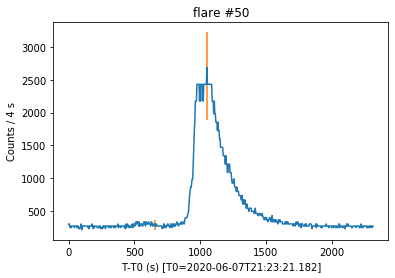

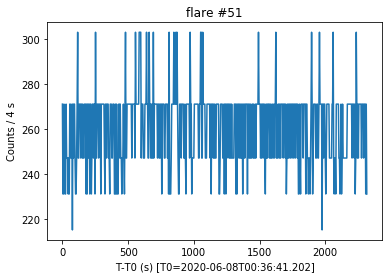

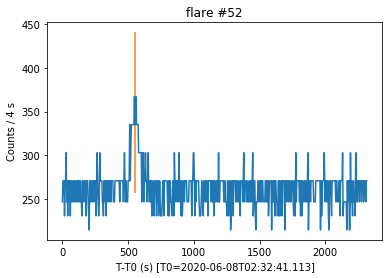

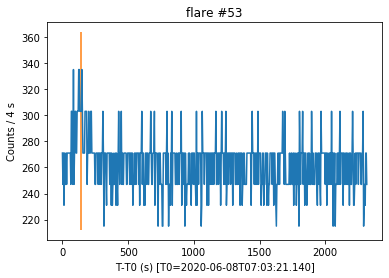

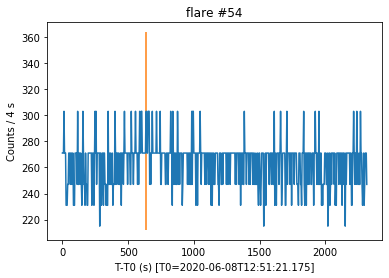

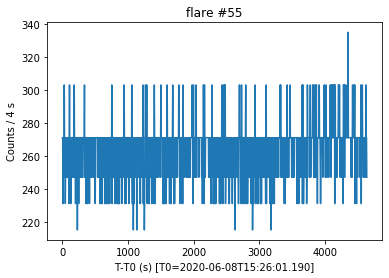

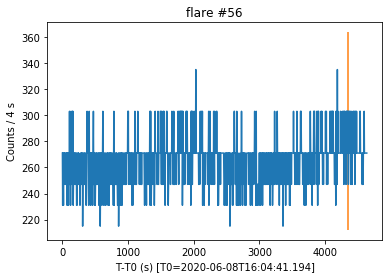

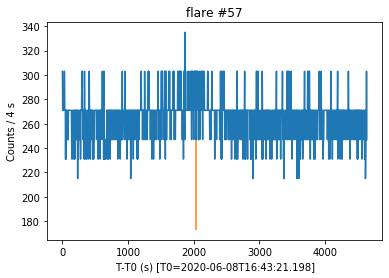

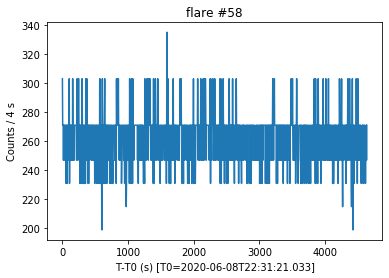

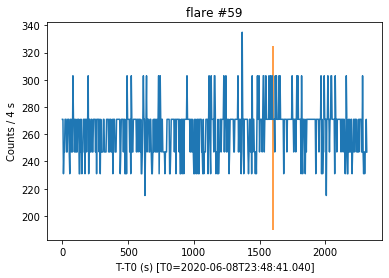

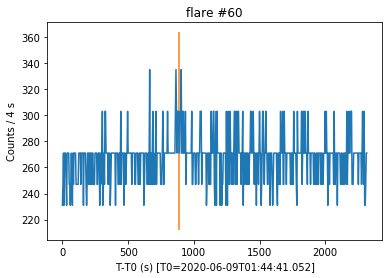

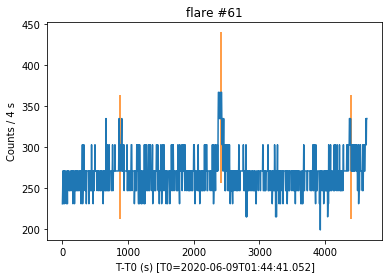

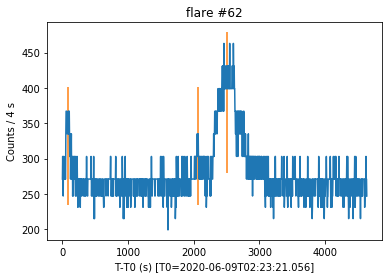

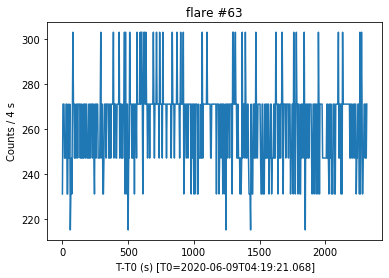

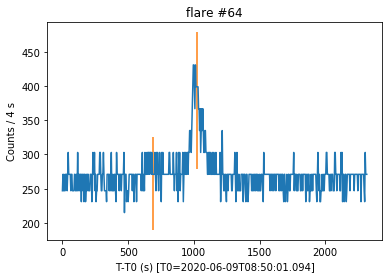

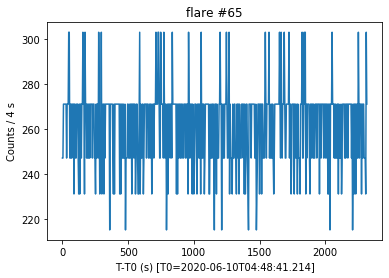

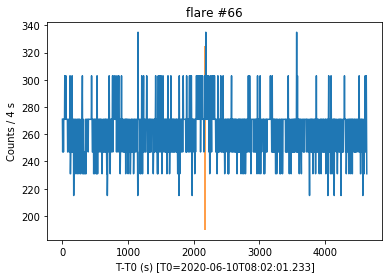

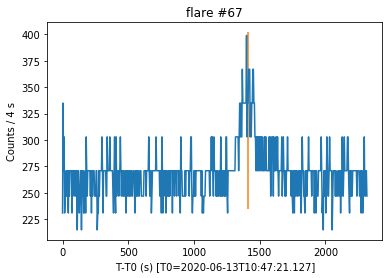

In [5]:

def find_peaks(data,filter_cutoff_freq=0.03, filter_order=4, 
        peak_min_width=15, peak_min_distance=75,  sigma=16 ): 
    
    lightcurve=data['lc']
    unix_time=data['t']
    _id=data['_id']
    if lightcurve is None:
        return
    
    
    #unix_time=[i*4 for i in range(0, np.size(lightcurve))]
    lc_mean=np.mean(lightcurve)
    lc_mean=260
    height=lc_mean+sigma
    b,a=scipy.signal.butter(filter_order, filter_cutoff_freq, 'low', analog=False) 
    lc_smoothed = scipy.signal.filtfilt(b, a, lightcurve)
    xpeaks, properties = scipy.signal.find_peaks(lc_smoothed,
                                                height=height,
                                                #threshold=threshold,
                                                width=peak_min_width,
                                                distance=peak_min_distance)

    fig = plt.figure()
    #time=[t-unix_time[0] for t in unix_time ]
    time=unix_time-unix_time[0]
    plt.plot(time, lightcurve)
    plt.title(f'flare #{_id}')
    plt.xlabel('T-T0 (s) [T0={}]'.format(stix_datetime.unix2utc(unix_time[0])))
    plt.ylabel('Counts / 4 s')
    if xpeaks.size>0:
    #plt.ylim(0.8*np.min(lightcurve),1.2*np.max(lightcurve))
        plt.vlines(time[xpeaks],lightcurve[xpeaks]*0.7, lightcurve[xpeaks]*1.2, color='C1')#, 'x')
    plt.show()
    
for fl in flare_data:
    find_peaks(fl)
    